# Clumpiness measures

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from collections import defaultdict
from itertools import product

import geopandas as gpd
import numpy as np
import pandas as pd
from itrx import Itr
from shapely import Polygon

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit, normalised_clumpiness
from utils import CATEGORIES, Month, load_crime_data, monthgen


In [24]:
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "GRID"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 200.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
# AREA_THRESHOLDS = [0.5, 0.25, 0.1]

In [25]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(36), filters={"Crime type": CATEGORY})
# remove any points outside boundary
raw_crime_data = raw_crime_data.sjoin(force_boundary)
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry,index_right,PFA23CD,PFA23NM
Crime ID,,,,,,,,,,,
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411838.68 447615.131),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Heather Court,E01010692,Bradford 001D,Anti-social behaviour,POINT (411526.994 447273.002),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Undercliffe Rise,E01010691,Bradford 002A,Anti-social behaviour,POINT (413203.97 446959.981),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Hangingstone Road,E01010691,Bradford 002A,Anti-social behaviour,POINT (413060.022 446952.013),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Sports/Recreation Area,E01010694,Bradford 002C,Anti-social behaviour,POINT (412011.181 448468.845),9,E23000010,West Yorkshire
...,...,...,...,...,...,...,...,...,...,...,...
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Close,E01011864,Wakefield 045A,Anti-social behaviour,POINT (444241.994 410485.05),9,E23000010,West Yorkshire
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Supermarket,E01011868,Wakefield 045C,Anti-social behaviour,POINT (445039.991 410940.983),9,E23000010,West Yorkshire
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Supermarket,E01011868,Wakefield 045C,Anti-social behaviour,POINT (445039.991 410940.983),9,E23000010,West Yorkshire


### Clumpiness index (CI)



In [26]:
def squares(nx: int, ny: int, length: float) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(
        geometry=[
            Polygon(
                [
                    (ix * length, iy * length),
                    ((ix + 1) * length, iy * length),
                    ((ix + 1) * length, (iy + 1) * length),
                    (ix * length, (iy + 1) * length),
                ]
            )
            for ix in range(nx)
            for iy in range(ny)
        ],
        crs="epsg:27700",
    )


def clumpiness_index(features: gpd.GeoDataFrame, total_area: float) -> float:
    external = features.union_all().length
    # each internal line is double-counted
    internal = (features.geometry.length.sum() - external) / 2

    g1 = internal / (internal + external)
    p1 = features.area.sum() / total_area

    # print(internal, external)
    # print(g1, p1)

    # Adepeju paper seems to be wrong
    # FRAGSTATS also seems dodgy
    # https://fragstats.org/index.php/fragstats-metrics/patch-based-metrics/aggregation-metrics/c4-clumpiness-index
    # If the proportion of like adjacencies (Gi) is greater than or equal to the proportion of the landscape comprised
    # of the focal class (Pi), then CLUMPY equals Gi minus Pi, divided by 1 minus Pi.
    # Likewise, if Gi < Pi, and Pi ≥ 0.5, then CLUMPY equals Gi minus Pi, divided by 1 minus Pi.
    # However, if Gi < Pi, and Pi < 0.5, then CLUMPY equals Pi minus Gi, divided by negative Pi.

    if g1 >= p1 or (p1 >= 0.5 and g1 < p1):
        return (g1 - p1) / (1 - p1)
    elif g1 < p1 and p1 < 0.5:
        return (g1 - p1) / p1
    else:
        return -1000

## Clumpiness measure

Requirements:
- essential:
    1. scale invariant (dimensionless quantity)
    2. intuitive scale with known bounds, e.g. 0 for completely dispersed, 1 for a single cluster with minimal perimeter  

- desirable:

    3. agnostic to shape of (regular) geometry
    4. works with irregular geometries (e.g. census geographies)

FRAGSTATS CI described by Adepeju does satisfies only one of these requirements. It is also poorly documented and
"hacky" and (potentially) discontinuous. The index value is impacted by the size of the background

Simple area/perimeter ratio is not scale invariant, nor is it intuitive.

But scale is integral to this - consider two disjoint squares of side $x$. At a length scale of $x$ this is a completely 
dispersed arrangement and a "clumpiness" value of 0 would be appropriate. However at a scale of $x/2$ this arrangement 
is two clusters of 4 squares and is thus to some degree clumpy. As the spatial scale decreased this arrangement must be 
considered to be more and more clumped.

Conversely applying a large length scale (say $10x$) on this arrangement becomes somewhat meaningless, so it is 
important that the length scale roughly represents a characteristic scale of the geometry.

Thus a length scale must be supplied to any unambiguous clumpiness calculation, and it can also be used to render 
quantities dimensionless, although in our case

To this end we compute upper and lower bounds, in units of the length scale $s$, for a square-based geometry with a 
given area $A$. The lower bound corresponds to length-unit squares arranged into a larger square:

$$
P_{min} = 4\sqrt{A}
$$

and the upper bound corresponds to $N=A/s^2$ disjoint length-unit squares:

$$
P_{max} = 4sN = \frac{4A}{s} 
$$

The clumpiness - the perimeter of the geometry in question - must then lie in between these two values (assuming a 
valid length scale has been chosen) and can be normalised:

$$
CI = \frac{P_{max} - P}{P_{max} - P_{min}}
$$

thus yielding a value of 0 for fully disjoint geometries (at the given length scale) and 1 for a geometry that minimises 
the perimeter (a square in this case)

In [28]:
# some real data
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])
count_data = crime_data.groupby(["spatial_unit", "Month"])["Crime type"].count().unstack(level="Month").fillna(0)
count_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
spatial_unit,,,,,,,,,,,,,,,,,,,,,
1870,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
2120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77859,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
78104,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


0.1656301833329366 200.0


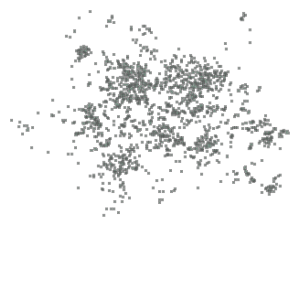

In [29]:
scale = np.sqrt(features.area.mean())
# scale = features.length.mean() / 4
# scale = np.exp(np.log(features.area).mean() / 2)

clumps = features.join(count_data["2025-04"])  # .explore()
clumps = clumps[clumps["2025-04"] > 0]
print(normalised_clumpiness(clumps, scale), scale)
clumps.union_all()

## Temporal variability

Shows clear signs of the seasonality detected in other measures (TODO which?)

More apparent with uniformly-sized features

<Axes: title={'center': 'Temporal variation of Clumpiness Index, West Yorkshire Anti-social behaviour'}, xlabel='Month', ylabel='Clumpiness Index'>

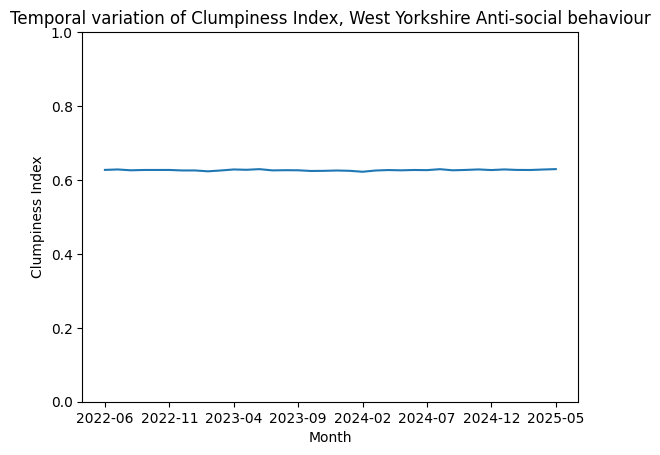

In [34]:
# compute clumpiness variation over time - strong seasonal variation
clumpiness = pd.Series(index=count_data.columns, name="CI")
for m in clumpiness.index:
    counts = count_data[m]
    counts = counts.cumsum().sort_values() / counts.sum()
    clumps = features.join(counts[counts >= 0.5])
    clumps = clumps[clumps[m] > 0]
    clumpiness.loc[m] = normalised_clumpiness(clumps, scale)

clumpiness.plot(ylim=(0, 1), ylabel="Clumpiness Index", title=f"Temporal variation of Clumpiness Index, {FORCE} {CATEGORY}")

## Spatial variability



<Axes: title={'center': 'Spatial variation of Clumpiness Index, West Yorkshire Anti-social behaviour'}, ylabel='Clumpiness Index'>

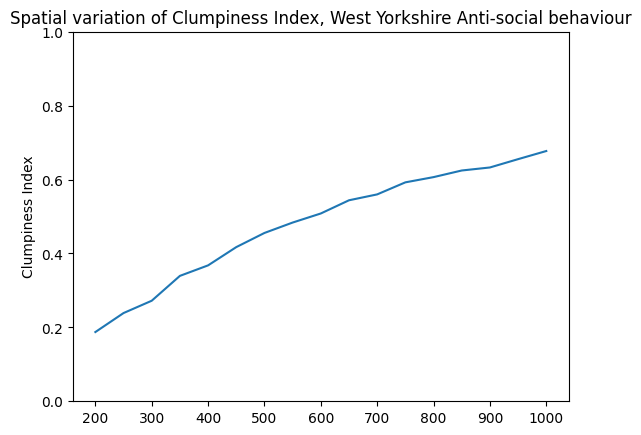

In [ ]:
AREA = "GRID"
SIZES = np.arange(200.0, 1000.1, 50.0)

crime_data1m = raw_crime_data[raw_crime_data.Month == str(LATEST_DATE)]

clumpiness = pd.Series(index=SIZES)

for size in clumpiness.index:
    crime_data, features = map_to_spatial_unit(crime_data1m, force_boundary, AREA, size=size)
    count_data = crime_data.groupby(["spatial_unit"])["Crime type"].count().rename("count")
    # features making up N% of crime
    count_data = count_data.cumsum().sort_values() / count_data.sum()
    count_data = count_data[count_data >= 0.5]

    clumps = features.join(count_data)
    clumps = clumps[clumps["count"] > 0]
    clumpiness.loc[size] = normalised_clumpiness(clumps, size)


clumpiness.plot(ylim=(0, 1), xlabel="Square grid length (m)", ylabel="Clumpiness Index", title=f"Spatial variation of Clumpiness Index, {FORCE} {CATEGORY}")

## Spatial stability

How does offsetting a regular grid affect clumpiness index?

In [10]:
AREA = "GRID"
SIZE = 200.0

OFFSETS = tuple(product((0, SIZE / 4, SIZE / 2, 3 * SIZE / 4), (0, SIZE / 4, SIZE / 2, 3 * SIZE / 4)))

crime_data1m = raw_crime_data[raw_crime_data.Month == "2025-04"]

clumpiness = pd.Series(index=OFFSETS)

for offset in clumpiness.index:
    crime_data, features = map_to_spatial_unit(crime_data1m, force_boundary, AREA, size=SIZE, offset=offset)
    count_data = crime_data.groupby(["spatial_unit"])["Crime type"].count().rename("count")
    # features making up N% of crime
    count_data = count_data.cumsum().sort_values() / count_data.sum()
    count_data = count_data[count_data >= 0.5]

    clumps = features.join(count_data)
    clumps = clumps[clumps["count"] > 0]
    clumpiness.loc[offset] = normalised_clumpiness(clumps, SIZE)

clumpiness.plot()

KeyboardInterrupt: 

In [9]:
clumpiness

NameError: name 'clumpiness' is not defined

0.3506261180679785
0.842389877887345


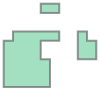

In [11]:
# Compare with FRAGSTATS measure

# Example from the Adepeju paper - our impl produces the value in the paper
f = squares(12, 11, 1).loc[
    [
        12,
        13,
        14,
        15,
        16,
        23,
        24,
        25,
        26,
        27,
        28,
        34,
        35,
        36,
        37,
        38,
        39,
        45,
        46,
        47,
        48,
        49,
        50,
        56,
        57,
        58,
        61,
        64,
        72,
        75,
        103,
        104,
        105,
        114,
        115,
    ]
]
print(clumpiness_index(f, 1 * 1 * 11 * 11))
print(normalised_clumpiness(f, 1))
# length = 100.0
f.geometry.union_all()

1.0


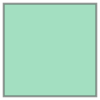

In [17]:
n = 11
g = squares(n, n, 1)[::1].geometry
# print(clumpiness_index(g, n * n))
print(normalised_clumpiness(g, 1.0))
g.union_all()

<Axes: >

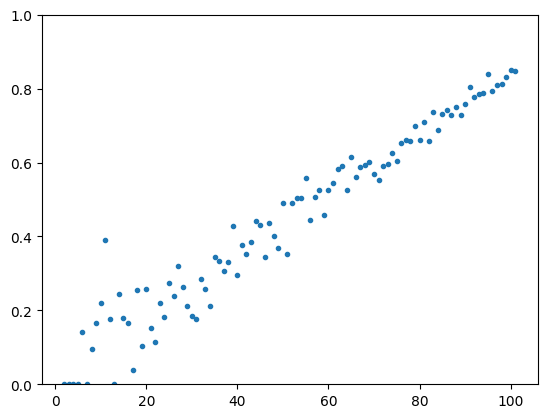

In [13]:
# randomly sample increasing number of squares
g = squares(n, n, 1)
# g = pd.concat([g[::2], g[1::2]])
s = pd.Series({i: normalised_clumpiness(g.sample(i), 1) for i in range(2, 102)})
s.plot(ylim=(0, 1), ls=" ", marker=".")

<Axes: xlabel='Squares filled in', ylabel='Clumpiness Index'>

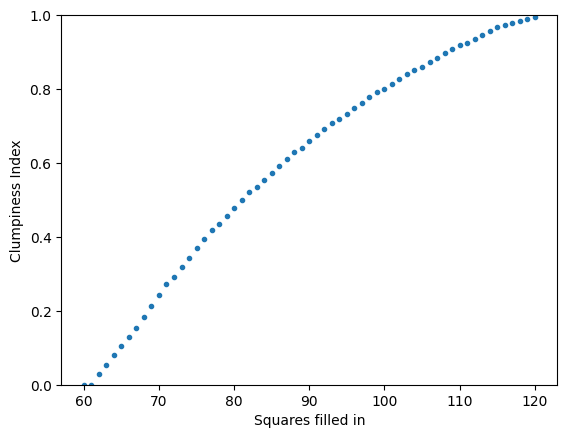

In [20]:
# start with fully dispersed and gradually fill in gaps
g2 = pd.concat([g[::2], g[1::2]])
s = pd.Series({i: normalised_clumpiness(g2[:i], 1.0) for i in range(len(g) // 2, len(g))})
s.plot(ylim=(0, 1), ls=" ", marker=".", xlabel="Squares filled in", ylabel="Clumpiness Index")
